# Artificial Neural Networks in Regression analysis
### Using Household and transpotation costs (% of income) and spatial lag to preduct Accessibility

In a regression problem, we aim to predict the output of a continuous value, in this case, the level of private accessibility over 10 minutes on the road network for blocks in Los Angeles County. 

In [44]:
from __future__ import absolute_import, division, print_function

import pathlib
import pickle
import seaborn as sns


import pandas as pd
import numpy as np
#pd.options.display.max_rows = 10

#import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
%matplotlib inline
pd.options.display.max_rows = 10

1.12.0


In [11]:
Data_clean_all_col = pd.read_csv('Spatial_weights_all.csv', delimiter = ',', encoding='latin-1', converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Data_clean_all_col['GEOID10']=Data_clean_all_col['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Data_clean_all_col.head()

,Unnamed: 0,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fourth_qui,Top_5_perc,perc_below,perc_bel_1,Less_high_,High_schoo,Black_Afri,Hispanic,White_Alon,populati_1
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566


In [12]:
Lag_pred_for_merge = pd.read_csv('Lag_pred_for_merge.csv', delimiter = ',',converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Lag_pred_for_merge['GEOID10']=Lag_pred_for_merge['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Lag_pred_for_merge.head()

,Unnamed: 0,GEOID10,populati_1,yb,lag_ht_ami,lag_Lowest_Qui,lag_Hispanic,lag_Black_Afri,lag_White_Alon,lag_Less_high_,...,Fit_1_Tot_r_10,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,060371011101000,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
1,2,060371011101007,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
2,3,060371011101008,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
3,4,060371011101011,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
4,5,060371011102004,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,30264.86623,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,93797.41,104498.48,83827.266,88984.016


In [13]:
All_data = Data_clean_all_col.merge(Lag_pred_for_merge,
                                    on='GEOID10')
All_data.head()

,Unnamed: 0_x,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fit_1_Tot_r_10,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,14996.78569,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,89468.05,96512.68,77364.130,80264.734
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,30264.86623,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,93797.41,104498.48,83827.266,88984.016


In [15]:
Sample_Data_clean = All_data[['Tot_r_10', 'ht_ami', 'lag_ht_ami']]
Sample_Data_clean

,Tot_r_10,ht_ami,lag_ht_ami
0,9407.8979,60.0,47.000000
1,10492.4500,60.0,47.000000
2,10283.7200,60.0,47.000000
3,10238.5000,60.0,47.000000
4,11543.9900,57.0,47.000000
...,...,...,...
16465,92774.4534,52.0,357.691471
16466,91699.3770,52.0,357.691471
16467,91699.3770,52.0,357.691471
16468,89253.7904,52.0,357.691471


In [16]:
train_dataset = Sample_Data_clean.sample(frac=0.8,random_state=0)
test_dataset = Sample_Data_clean.drop(train_dataset.index)
test_dataset

,Tot_r_10,ht_ami,lag_ht_ami
0,9407.8979,60.000000,47.000000
13,13052.2800,47.000000,69.000000
21,20115.7300,75.000000,0.000000
25,12751.4857,55.000000,53.000000
26,11355.1029,55.000000,53.000000
...,...,...,...
16443,90761.0929,44.000000,166.691471
16447,91382.7025,44.000000,166.691471
16456,94307.4831,60.586042,160.000000
16463,84007.9313,52.000000,357.691471


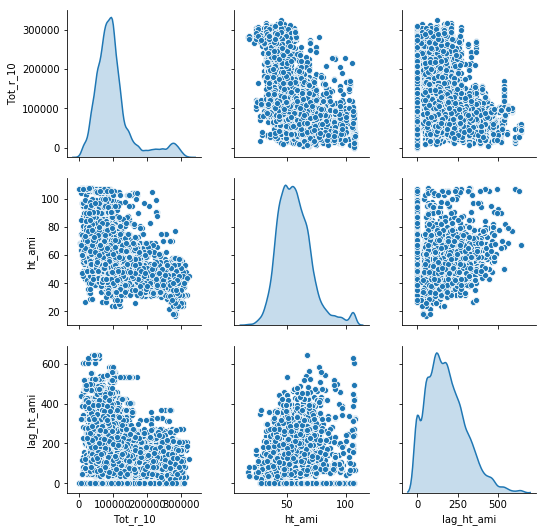

In [17]:
sns.pairplot(train_dataset[["Tot_r_10", "ht_ami", "lag_ht_ami"]], diag_kind="kde")


In [18]:
train_stats = train_dataset.describe()
train_stats.pop("Tot_r_10")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ht_ami,13176.0,56.879521,14.405075,17.0,47.0,55.0,65.0,108.0
lag_ht_ami,13176.0,179.196664,120.868119,0.0,90.0,167.5,255.0,641.0


In [19]:
train_labels = train_dataset.pop('Tot_r_10')
test_labels = test_dataset.pop('Tot_r_10')

#### Normalize the data
Look again at the train_stats block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

In [20]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [21]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [14]:
Dense = tf.keras.layers.Dense

In [15]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [16]:
model = build_model()

#### Inspect the model

Use the `.summary` method to print a simple description of the model

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.11567431],
       [-0.01626014],
       [-0.01709709],
       [-0.05622862],
       [-0.04152046],
       [-0.00998581],
       [-0.06895594],
       [-0.03939701],
       [-0.05318034],
       [-0.04434357]], dtype=float32)

#### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [19]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the history object.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('hist_ANN2.csv', sep=',')
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,2.186952e+09,34064.085804,2.186952e+09,2.118927e+09,33204.756893,2.118927e+09,995
996,2.184282e+09,33928.107620,2.184282e+09,2.118625e+09,33238.371774,2.118625e+09,996
997,2.185628e+09,34005.115584,2.185628e+09,2.118950e+09,33191.700906,2.118950e+09,997
998,2.186806e+09,34080.655918,2.186806e+09,2.118911e+09,33174.429759,2.118911e+09,998
999,2.185684e+09,34033.444367,2.185684e+09,2.119019e+09,33213.651263,2.119019e+09,999


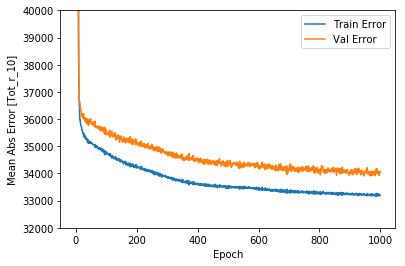

In [36]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Tot_r_10]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()
    plt.ylim([32000,40000])
    plt.savefig("ANN2.png", format="PNG")



plot_history(history)


This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [5]:
model.save('./ANN_2/ANN_ht_ami_ht_ami_lag.model')

NameError: name 'model' is not defined

In [33]:
model_from_save = tf.keras.models.load_model('./ANN_2/ANN_ht_ami_ht_ami_lag.model')

In [34]:
full_normed_data = norm(All_data[['ht_ami', 'lag_ht_ami']]).values

In [35]:
prediction = model_from_save.predict(full_normed_data)

In [36]:
prediction.mean()

103423.83

In [37]:
prediction = pd.DataFrame(prediction, columns=['ANN_2_Tot_r_10']).to_csv('./ANN_2/prediction_ANN_2.csv')

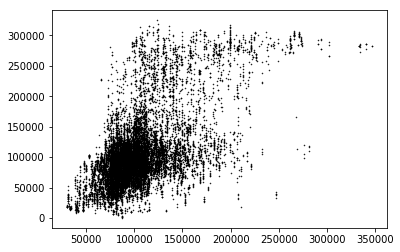

In [25]:
plt.scatter(prediction, All_data.Tot_r_10,color='k', marker='.', s=1)

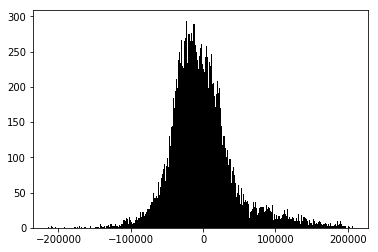

In [28]:
plt.hist(All_data.Tot_r_10 - prediction.flatten(), bins=300, color='k')
plt.savefig("ANN2_hist.png", format="PNG")

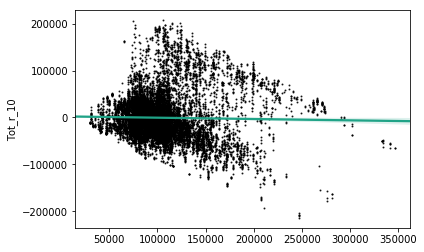

In [29]:
sns.regplot(prediction, 
            All_data.Tot_r_10 - prediction.flatten(),
            scatter_kws=dict(color='k', marker='.', s=1), 
            line_kws=dict(color='#20A387'))
plt.savefig("ANN2_scatter.png", format="PNG")

# Comparing MLM and ANN

In [28]:
prediction_MLM = pd.read_csv('./ht_ami and lag_ht_ami/Pred_3_1_trans.csv')
prediction_MLM.head()

,Unnamed: 0,21999
0,y_hat[1],853.474224
1,y_hat[2],853.474224
2,y_hat[3],853.474224
3,y_hat[4],853.474224
4,y_hat[5],-3581.635544


In [38]:
prediction_ANN = pd.read_csv('./ANN_2/prediction_ANN_2.csv')
prediction_ANN.head()

,Unnamed: 0,ANN_2_Tot_r_10
0,0,96832.89
1,1,96832.89
2,2,96832.89
3,3,96832.89
4,4,104029.99


In [39]:
y_pred_ANN = prediction_ANN['ANN_2_Tot_r_10']
y_pred_MLM = prediction_MLM['21999']
y_true = All_data['Tot_r_10']

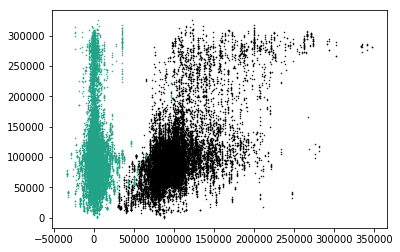

In [40]:
plt.scatter(y_pred_ANN, y_true,color='k', marker='.', s=1)
plt.scatter(y_pred_MLM, y_true,color='#20A387', marker='.', s=1)

plt.show()

In [26]:
def r2(pred, obs):
    ess = (pred - obs).T @ (pred - obs)
    tss = obs.var() * obs.shape[0]
    return 1-ess/tss

In [42]:
import sklearn 
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_pred_ANN)

33445.333572204014

In [45]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred_ANN): 
    y_true, y_pred_ANN = check_array(y_true, y_pred_ANN)
return np.mean(np.abs((y_true - y_pred_ANN) / y_true)) * 100


46.746639725906185

In [32]:
import numpy

In [27]:
r2(prediction, All_data[['Tot_r_10']])

,Tot_r_10
Tot_r_10,0.347466


In [ ]:
full_normed_data = pd.DataFrame(full_normed_data, columns=['ht_ami']).to_csv('data_ANN_2.csv')

In [ ]:
prediction = pd.DataFrame(prediction, columns=['predictions']).to_csv('prediction_ANN_2.csv')